In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.plots as plots

# open database use OpsimDatabase
opsdb = db.OpsimDatabase('baseline2018a.db')
# output
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots

In [2]:
#del TDEsMetricTest
from mycode.TDEsMetricTest import TDEsMetricTest

In [ ]:
# source code of TDEsMetricTest
from builtins import zip
from functools import reduce

import os
import numpy as np
from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.utils as utils

__all__ = ['TDEsMetricTest']

class TDEsMetricTest(BaseMetric):
    """Based on the transientMetric, but uses an ascii input file and provides option to write out lightcurve.
    
    Calculate what fraction of the transients would be detected. Best paired with a spatial slicer.
    The lightcurve in input is an ascii file per photometric band so that different lightcurve
    shapes can be implemented.

    Parameters
    ----------
    asciifile : str
        The ascii file containing the inputs for the lightcurve (per filter):
        File should contain three columns - ['ph', 'mag', 'flt'] -
        of phase/epoch (in days), magnitude (in a particular filter), and filter.
    
    detectSNR : dict, optional
        An observation will be counted toward the discovery criteria if the light curve SNR
        is higher than detectSNR (specified per bandpass).
        Values must be provided for each filter which should be considered in the lightcurve.
        Default is {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}
    

    dataout : bool, optional
        If True, metric returns full lightcurve at each point. Note that this will potentially
        create a very large metric output data file.
        If False, metric returns the number of transients detected.
    """
    def __init__(self, asciifile, metricName='TDEsMetricTest', mjdCol='expMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 peakEpoch=0, nearPeakT=5, 
                 nObsTotal = {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 nObsPrePeak = 0,
                 nObsNearPeak={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                 nFiltersNearPeak = 0, 
                 nObsPostPeak = 0,
                 nPhaseCheck = 1, epochStart = 0, 
                 dataout=False, **kwargs):
        
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.dataout = dataout

        # condition parameters
        self.detectSNR = detectSNR
        self.peakEpoch = peakEpoch
        self.nearPeakT = nearPeakT
        self.nObsTotal = nObsTotal
        self.nObsPrePeak = nObsPrePeak
        self.nObsNearPeak = nObsNearPeak
        self.nFiltersNearPeak = nFiltersNearPeak
        self.nObsPostPeak = nObsPostPeak
        self.epochStart = epochStart
        self.nPhaseCheck = nPhaseCheck

        # if you want to get the light curve in output you need to define the metricDtype as object
        if self.dataout:
            super(TDEsMetricTest, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       metricDtype='object', units='', 
                                                       metricName='TDEsMetricTest', **kwargs)
        else:
            super(TDEsMetricTest, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       units='Fraction Detected', 
                                                       metricName='TDEsMetricTest', **kwargs)
        self.read_lightCurve(asciifile)
    
        print('Finish initializing metric')

    def read_lightCurve(self, asciifile):
        
        if not os.path.isfile(asciifile):
            raise IOError('Could not find lightcurve ascii file %s' % (asciifile))

        self.lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])

    def make_lightCurve(self, time, filters):
                
        lcv_template = self.lcv_template
        
        lcMags = np.zeros(time.size, dtype=float)
        
        for f in set(lcv_template['flt']):
            fMatch_ascii = np.where(np.array(lcv_template['flt']) == f)[0]
            
            # Interpolate the lightcurve template to the times of the observations, in this filter.
            lc_ascii_filter = np.interp(time, np.array(lcv_template['ph'], float)[fMatch_ascii],
                                            np.array(lcv_template['mag'], float)[fMatch_ascii])
            lcMags[filters == f.decode("utf-8")] = lc_ascii_filter[filters == f.decode("utf-8")]
        
        return lcMags

    def snr2std(self, snr):
        std = 2.5 * np.log10(1 + 1/snr)
        return std 

    def run(self, dataSlice, slicePoint=None):
        """"Calculate the detectability of a transient with the specified lightcurve.

        If self.dataout is True, then returns the full lightcurve for each object instead of the total
        number of transients that are detected.

        Parameters
        ----------
        dataSlice : numpy.array
            Numpy structured array containing the data related to the visits provided by the slicer.
        slicePoint : dict, optional
            Dictionary containing information about the slicepoint currently active in the slicer.

        Returns
        -------
        float or list of dicts
            The total number of transients that could be detected. (if dataout is False)
            A dictionary with arrays of 'lcNumber', 'lcMag', 'detected', 'time', 'detectThresh', 'filter'
        """

        # Sort the entire dataSlice in order of time.  
        dataSlice.sort(order=self.mjdCol)
        tSpan = (dataSlice[self.mjdCol].max() - dataSlice[self.mjdCol].min()) # in days
        
        lcv_template = self.lcv_template
        transDuration = lcv_template['ph'].max() - lcv_template['ph'].min() # in days

        # phase check
        tshifts = np.arange(self.nPhaseCheck) * transDuration / float(self.nPhaseCheck)

        lcNumber = np.floor((dataSlice[self.mjdCol] - dataSlice[self.mjdCol].min()) / transDuration)
        ulcNumber = np.unique(lcNumber)

        nTransMax = 0
        nDetected = 0
        dataout_dict_list = []
        for tshift in tshifts:
            #print('check tshift ', tshift)
            lcEpoch = np.fmod(dataSlice[self.mjdCol] - dataSlice[self.mjdCol].min() + tshift, transDuration) + self.epochStart
     
            # total number of transients possibly detected
            nTransMax += np.ceil(tSpan/transDuration)

            # generate the actual light curve
            lcFilters = dataSlice[self.filterCol]
            lcMags = self.make_lightCurve(lcEpoch, lcFilters)
            lcSNR = utils.m52snr(lcMags, dataSlice[self.m5Col])

            # Identify detections above SNR for each filter
            lcAboveThresh = np.zeros(len(lcSNR), dtype=bool)
            for f in np.unique(lcFilters):
                filtermatch = np.where(dataSlice[self.filterCol] == f)
                lcAboveThresh[filtermatch] = np.where(lcSNR[filtermatch] >= self.detectSNR[f], True, False)
                
            # check conditions for each light curve
            lcDetect = np.ones(len(ulcNumber), dtype=bool)
            lcDetectOut = np.ones(len(lcNumber), dtype=bool)
            for i, lcN in enumerate(ulcNumber):

                lcN_idx = np.where(lcNumber == lcN)
                lcEpoch_i = lcEpoch[lcN_idx]
                lcMags_i = lcMags[lcN_idx]
                lcFilters_i = lcFilters[lcN_idx]
                lcAboveThresh_i = lcAboveThresh[lcN_idx]
                
                #check total number of observations for each band
                for f in np.unique(lcFilters_i):
                    f_Idx = np.where(lcFilters_i==f)
                    if len( np.where(lcAboveThresh_i[f_Idx])[0] ) < self.nObsTotal[f]:
                        lcDetect[i] = False
                        lcDetectOut[lcN_idx] = False
                
                ## prePeakCheck 
                prePeakCheck = (lcEpoch_i < self.peakEpoch)
                prePeakIdx = np.where(prePeakCheck == True)
                # number of observations before peak
                if len( np.where(lcAboveThresh_i[prePeakIdx])[0] ) < self.nObsPrePeak:
                    lcDetect[i] = False
                    lcDetectOut[lcN_idx] = False

                ## near Peak 
                nearPeakCheck = (lcEpoch_i >= self.peakEpoch - self.nearPeakT/2) & (lcEpoch_i <= self.peakEpoch + self.nearPeakT/2) 
                nearPeakIdx = np.where(nearPeakCheck==True)
                
                # check number of observations near peak for each band
                for f in np.unique(lcFilters_i):
                    nearPeakIdx_f = np.intersect1d( nearPeakIdx, np.where(lcFilters_i==f) )

                    if len( np.where(lcAboveThresh_i[nearPeakIdx_f])[0] ) < self.nObsNearPeak[f]:
                        print('filter ', f, 'condition works')
                        lcDetect[i] = False
                        lcDetectOut[lcN_idx] = False

                # check number of filters near peak
                filtersNearPeakIdx = np.intersect1d(nearPeakIdx, np.where(lcAboveThresh)[0])

                if len( np.unique(lcFilters_i[filtersNearPeakIdx]) ) < self.nFiltersNearPeak:
                        lcDetect[i] = False
                        lcDetectOut[lcN_idx] = False

                ## check number of observations post peak
                # postPeakCheck 
                postPeakCheck = (lcEpoch_i > self.peakEpoch)
                postPeakIdx = np.where(postPeakCheck == True)
                # number of observations before peak
                if len( np.where(lcAboveThresh_i[postPeakIdx])[0] ) < self.nObsPostPeak:
                    lcDetect[i] = False
                    lcDetectOut[lcN_idx] = False

            # return values   
            nDetected += len(np.where(lcDetect == True)[0])

            #print(nTransMax, nDetected, lcDetect)


            dataout_dict_tshift = {'tshift': tshift, 
                        'expMJD' : dataSlice[self.mjdCol],
                        'm5' : dataSlice[self.m5Col],
                        'filters': dataSlice[self.filterCol],
                        'lcNumber': lcNumber,
                        'lcEpoch': lcEpoch,
                        'lcMags': lcMags,
                        'lcSNR': lcSNR, 
                        'lcMagsStd': self.snr2std(lcSNR),
                        'lcAboveThresh': lcAboveThresh,
                        'detected': lcDetectOut}

            dataout_dict_list.append(dataout_dict_tshift)

        if self.dataout:

            return dataout_dict_list

        else:   
            return float(nDetected / nTransMax) if nTransMax!=0 else 0.



## get skymap 

Finish initializing metric
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night<300 for columns ['observationStartMJD', 'fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter']
Found 195853 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<300" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.980654  dipole: lon: -164.097, lat: -5.36978, amp: 0.0423857
Plotting complete.


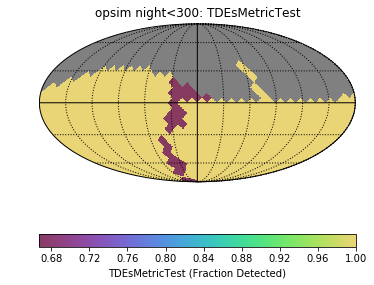

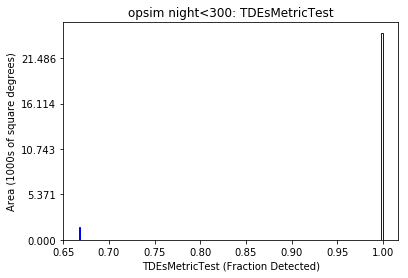

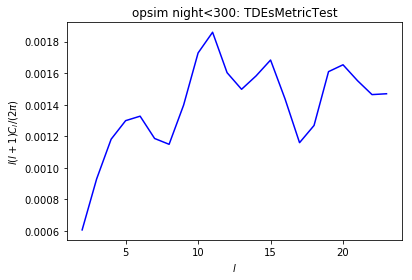

In [3]:
# run the metric
asciifile = 'TDEfaintfast_z0.1.dat'
transmetric = TDEsMetricTest(asciifile=asciifile, metricName='TDEsMetricTest', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 peakEpoch=0, nearPeakT=5, 
                 nObsTotal = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}, 
                 nObsPrePeak = 0,
                 nObsNearPeak={'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0},
                 nFiltersNearPeak = 0, 
                 nPhaseCheck = 1, epochStart = -22, 
                 dataout=False)
                 
slicer = slicers.HealpixSlicer(nside=8) 
sqlconstraint = 'night<300'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

## get light curve

In [4]:
# run the metric
asciifile = 'TDEfaintfast_z0.1.dat'
transmetric = TDEsMetricTest(asciifile=asciifile, metricName='TDEsMetricTest', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 peakEpoch=0, nearPeakT=5, 
                 nObsTotal = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}, 
                 nObsPrePeak = 0,
                 nObsNearPeak={'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0},
                 nFiltersNearPeak = 0, 
                 nPhaseCheck = 1, epochStart = -22, 
                 dataout=True)

#slicer = slicers.HealpixSlicer(nside=8)
ra = np.array([34.39339593])
dec = np.array([-5.09032894])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<700'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

Finish initializing metric
Querying database SummaryAllProps with constraint night<700 for columns ['observationStartMJD', 'fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter']
Found 431650 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<700" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


In [5]:
output_dict_list = transmetricSky.metricValues.data[0]
df = pd.DataFrame(output_dict_list[0])

# pd.set_option('display.max_rows', 2000) # set max number of rows to display
df.head()

,detected,expMJD,filters,lcAboveThresh,lcEpoch,lcMags,lcMagsStd,lcNumber,lcSNR,m5,tshift
0,True,59853.282894,i,False,-22.000000,31.090000,5.726492,0.0,0.005148,23.621657,0.0
1,True,59853.296551,i,False,-21.986343,31.079447,5.826334,0.0,0.004694,23.510772,0.0
2,True,59854.272384,y,False,-21.010509,30.864389,6.720510,0.0,0.002054,22.398682,0.0
3,True,59857.266632,z,False,-18.016262,28.492462,3.707311,0.0,0.034010,23.074038,0.0
4,True,59857.277535,z,False,-18.005359,28.485326,3.672504,0.0,0.035156,23.102912,0.0


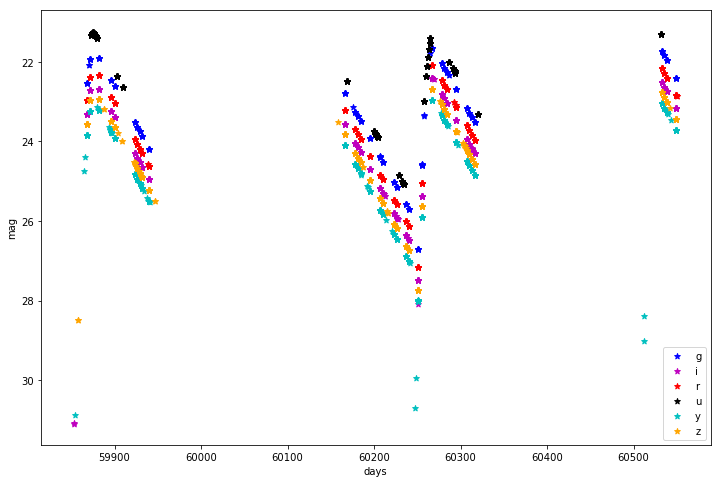

In [6]:
def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter'):
    colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}
    
    plt.figure(figsize=(12, 8))
    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]

        plt.scatter(time, mag, color=colors[f], marker='*', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])

plotlc(df, time_key='expMJD', mag_key='lcMags', filter_key='filters')


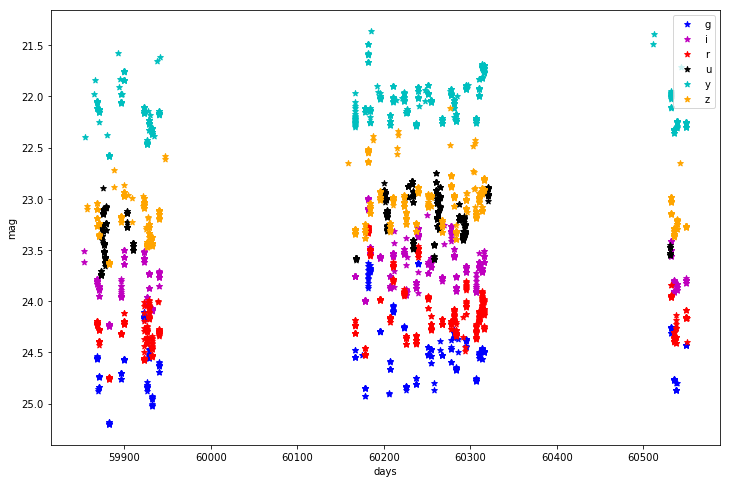

In [7]:
plotlc(df, time_key='expMJD', mag_key='m5', filter_key='filters')
